In [1]:
import os
import plotly.graph_objs as go
from plotly.offline import iplot
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('../')

# set autoreload to reload all external modules automatically (otherwise changes to those modules won't take effect in the notebook)
%load_ext autoreload
%autoreload 2

from _util.make_folder_dataset import MakeFolderDataset

In [3]:
#load environment variables from .env file in repo root
%load_ext dotenv
%dotenv

#DATASET_REPO_ROOT_PATH=<absolute-path-to-dataset-repo-root-folder>
dataset_repo_root_path = Path(os.environ.get("DATASET_REPO_ROOT_PATH"))

In [4]:
# set True / False to enable / disable data set persisting
save_dataset = input("Save dataset (Y/N)?") == "Y"
use_test_data = input("Test data (Y/N)?") == "Y"

# offset of (sliding) window right border from time of contact in miliseconds (default = 100ms)
# step for sliding window (default = 4 timesteps)
window_right_offset_ms = 100
sliding_window_step = 4
x_y_data_suffix = ""
if use_test_data == False:
    window_right_offset_ms = input(
        "offset of right window border from time of contact in ms (default: 100): ")
    window_right_offset_ms = int(
        window_right_offset_ms) if window_right_offset_ms != "" else 100
    sliding_window_step = input("sliding window step (default: 4): ")
    sliding_window_step = int(
        sliding_window_step) if sliding_window_step != "" else 4
    x_y_data_suffix = x_y_data_suffix + \
        f"offset{window_right_offset_ms}ms_step{sliding_window_step}"

if save_dataset:
    additional_suffix = input("additional file suffix")
    x_y_data_suffix = x_y_data_suffix + \
        ("_TESTDATA" if use_test_data else additional_suffix)

specific_instances = None

# plots everything if None, nothing if [], specific targets if [<list-of-targets>]
# ["q0", "q_d0", "e0", "dq0", "dq_d0", "de0"]
specific_plot_target = []

In [5]:
# load dataset instances
# use current git repo root folder as a reliable "base" folder. Dataset folders should be under <git-root>\dataset\
instances: list[MakeFolderDataset] = []
raw_data_path = dataset_repo_root_path / ("rawData" if use_test_data == False else "testData")
for p in raw_data_path.iterdir():
    if specific_instances is not None and p.name not in specific_instances:
        continue
    if p.is_dir() and not p.name == "_ignore":
        instance = MakeFolderDataset(p.absolute())
        instance.extract_robot_data()
        instance.get_labels_all()
        instances.append(instance)

instances = sorted(instances, key=lambda i: i.name)

print(f"found {len(instances)} instances")

found 86 instances


In [6]:
# add contact labels from true_label dataframe to robot-data dataframe for all instances
for inst in instances:
    inst.df = pd.merge_asof(left=inst.df, right=inst.true_label[["time", "DATA0"]], on="time", tolerance=0.02)
    inst.df.rename(columns={"DATA0": "has_contact"}, inplace=True)
    inst.df["has_contact"] = inst.df["has_contact"].fillna(0)

    if inst.df.loc[1, 'has_contact'] == 1:
        inst.df.loc[0, 'has_contact'] = 1

In [7]:
# clean up faulty (true_label) sensor data
# IMPORTANT: assume that the first measurement (time-window with has_contact = 1) is correct and can be used as a reference point to clean the remaining instance
# thus it must manually be verified that the first measurement of each instance is indeed correct

def get_contact_duration(df, time):
    start_time_index = df[(df['time'] < time) & (
        df['has_contact'] == 0)].index[-1] + 1
    start_time = df.loc[start_time_index, 'time']
    try:
        end_time_index = df[(df['time'] > time) & (
            df['has_contact'] == 0)].index[0] - 1
    except IndexError:
        # occurs if filtered df above is empty, which means there is no row with has_contact = 0 after specified time
        end_time_index = df.index[-1]
    end_time = df.loc[end_time_index, 'time']
    return (end_time - start_time), start_time, end_time


def get_next_contact_time(df, excl_from_time):
    # time of contact time-window must always be greater than time of 1st no-contact
    # -> exclude any cut-off contact time-windows at start of measurement
    first_no_contact_time = df[df['has_contact'] == 0].iloc[0]['time']
    filtered_df = df[(df['time'] > first_no_contact_time) & (
        df['time'] > excl_from_time) & (df['has_contact'] == 1)]
    return (filtered_df.iloc[0]['time'], filtered_df.index[0]) if len(filtered_df) > 0 else (None, None)


for inst in instances:
    inst.df['has_contact_original'] = inst.df.loc[:, 'has_contact']

    # calculate duration of 1st contact time-window
    # 1st contact time-window starts at 1st row with has_contact = 1, where a previous row with has_contact = 0 exists
    contact_time, _ = get_next_contact_time(inst.df, inst.start_from_time)
    reference_duration, reference_start_time, reference_end_time = get_contact_duration(
        inst.df, contact_time)

    # set has_contact to 0 for all rows before 1st actuall contact time-window
    inst.df.loc[inst.df["time"] < contact_time, "has_contact"] = 0

    # inst.first_contact_start_time = reference_start_time
    # inst.window_size = window_size = len(inst.df[(inst.df['time'] >= reference_start_time) & (
    #    inst.df['time'] <= reference_end_time)])

    # set has_contact to 0 for all contact time-windows with duration outside of [<lower-bound-multiplier>*reference_duration, <upper-bound-multiplier>*reference_duration]
    # -> remove faulty time-windows
    # multiplier values can be set manually in meta.json, defaults are 0.85 and 1.2
    last_contact_end_time = reference_end_time
    reference_duration_multiplier_lower = inst.reference_duration_multiplier_lower if inst.reference_duration_multiplier_lower is not None else 0.85
    reference_duration_multiplier_upper = inst.reference_duration_multiplier_upper if inst.reference_duration_multiplier_upper is not None else 1.2
    while True:
        contact_time, _ = get_next_contact_time(inst.df, last_contact_end_time)
        if contact_time is None:
            break
        contact_duration, contact_start_time, contact_end_time = get_contact_duration(
            inst.df, contact_time)
        if not (reference_duration_multiplier_lower * reference_duration <= contact_duration <= reference_duration_multiplier_upper * reference_duration):
            # print(contact_duration, contact_start_time, contact_end_time)
            inst.df.loc[(inst.df['time'] >= contact_start_time) & (
                inst.df['time'] <= contact_end_time), 'has_contact'] = 0
        last_contact_end_time = contact_end_time

In [8]:
target_torque = ['tau_J0', 'tau_J1', 'tau_J2','tau_J3', 'tau_J4', 'tau_J5', 'tau_J6']
target_position = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
target_velocity = ['dq0', 'dq1', 'dq2', 'dq3', 'dq4', 'dq5', 'dq6']

target_torque_err = ['etau_J0','etau_J1', 'etau_J2', 'etau_J3', 'etau_J4', 'etau_J5', 'etau_J6']
target_position_err = ['e0','e1','e2','e3','e4','e5','e6']
target_velocity_err = ['de0','de1','de2','de3','de4','de5','de6']

targets = target_torque + target_position + target_velocity
error_targets = target_torque_err + target_position_err + target_velocity_err

all_targets = targets + error_targets

plot_target = all_targets if specific_plot_target is None else specific_plot_target
for inst in instances:
    for i in plot_target:
        # label gets scaled otherwise measure and label are not visible properly on plot
        A = inst.df[i].max()-inst.df[i].min()
        inst.df['has_contact_scaled'] = inst.df['has_contact'] * \
            A + inst.df[i].min()
        inst.df['has_contact_original_scaled'] = inst.df['has_contact_original'] * \
            A + inst.df[i].min()
        # use plotly to make interactive plots
        trace_has_contact = go.Scatter(
            x=inst.df['time'], y=inst.df['has_contact_scaled'], name='has contact')
        trace_has_contact_original = go.Scatter(
            x=inst.df['time'], y=inst.df['has_contact_original_scaled'], name='has contact original')
        trace_robotdata = go.Scatter(
            x=inst.df['time'], y=inst.df[i], mode='lines', name='robot data')
        data = [trace_has_contact_original, trace_robotdata, trace_has_contact]
        layout = go.Layout(title=f'{i} (instance {os.path.basename(os.path.normpath(inst.path))})',
                           xaxis=dict(title='time(sec)'),
                           yaxis=dict(title='Y-axis'))
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)

In [9]:
def save_data(X, y, X_filename, y_filename, subfolder_name=""):
    processed_data_path = dataset_repo_root_path / "processedData"
    processed_data_path = processed_data_path / \
        subfolder_name if use_test_data == False else processed_data_path / "TESTSET"
    X_path = processed_data_path / X_filename
    y_path = processed_data_path / y_filename
    print(
        f"saving dataset as: {str(X_path.absolute())} / {str(y_path.absolute())}")
    np.save(str(X_path.absolute()), X)
    np.save(str(y_path.absolute()), y)


# count instances (per contact class) per motion
motion_instance_total_counts = {}
motion_instance_current_counts = {}
for inst in instances:
    motion_instance_current_counts[inst.motion] = {
        "soft": 0, "hard": 0, "pvc_tube": 0}
    total_counts = motion_instance_total_counts.get(
        inst.motion, {"soft": 0, "hard": 0, "pvc_tube": 0})
    total_counts[inst.contact_type] = total_counts[inst.contact_type] + 1
    motion_instance_total_counts[inst.motion] = total_counts

print("Number of instances per motion:")
for k, v in motion_instance_total_counts.items():
    soft_count, hard_count, pvc_count = v["soft"], v["hard"], v["pvc_tube"]
    print(f"{k}: {soft_count} soft, {hard_count} hard, {pvc_count} pvc")
print()

# complete dataset: one numpy dataset with samples of all instances
X_single_left_offset, y_single_left_offset = [], []
X_sliding_left_offset, y_sliding_left_offset = [], []

# split dataset: split one instance per motion off as test set, rest as training set
X_split_train_single_left_offset, y_split_train_single_left_offset = [], []
X_split_test_single_left_offset, y_split_test_single_left_offset = [], []
X_split_train_sliding_left_offset, y_split_train_sliding_left_offset = [], []
X_split_test_sliding_left_offset, y_split_test_sliding_left_offset = [], []

# 40 data points with robot data publish frequency of 200Hz -> 200ms time-windows
window_size = 40

# offset on the left border of a time window with freq. of 200Hz (timestep length = 5ms): right offset in ms / 5ms per timestep - window size
# for test data, we want the 1st window to start at the beginning of the contact (right window border at time of contact), as this is when the model is inferred online
window_left_offset = int((window_right_offset_ms / 5) -
                         window_size) if use_test_data == False else (-1) * window_size

for inst in instances:
    contact_end_time = -1
    current_nof_samples, max_nof_samples = 0, 3

    # append to train split set unless current inst is the last instance per motion and contact class
    current_count = motion_instance_current_counts[inst.motion][inst.contact_type]
    append_to_train = current_count < (motion_instance_total_counts[
        inst.motion][inst.contact_type] - 1)
    motion_instance_current_counts[inst.motion][inst.contact_type] = current_count + 1

    # take 3 samples per instance to keep class / motion balance
    while current_nof_samples < max_nof_samples:
        contact_time, contact_time_index = get_next_contact_time(
            inst.df, contact_end_time)
        if contact_time is None:
            break

        _, _, contact_end_time = get_contact_duration(inst.df, contact_time)

        # append contact time-windows to feature matrices
        if contact_time_index + window_left_offset >= 0:
            current_nof_samples += 1
            instance_contact_id = f"{inst.name}_{str(current_nof_samples)}"

            # window thats starts left (by defined offset) of time of contact, with fixed window size
            left_offset_window = inst.df.iloc[contact_time_index + window_left_offset:contact_time_index +
                                              window_left_offset + window_size][all_targets].to_numpy()
            # append to complete dataset
            X_single_left_offset.append(left_offset_window)
            y_single_left_offset.append(inst.contact_type)

            # append to train or test split set
            if append_to_train:
                X_split_train_single_left_offset.append(left_offset_window)
                y_split_train_single_left_offset.append(inst.contact_type)
            else:
                X_split_test_single_left_offset.append(left_offset_window)
                y_split_test_single_left_offset.append(inst.contact_type)

            # sliding window: start left (by offset) of time of contact, fixed window size
            # move sliding window to the right by specified step (timestep = #rows, one step = 5ms) each step and append until end of contact time-window is reached by right side of sliding window,
            # or until offset equals 20 (-> left window border at 100ms after initial contact) to avoid including data too late after initial contact
            window_current_offset = window_left_offset
            sliding_left_offset_windows_x, sliding_left_offset_windows_y = [], []
            while inst.df.iloc[contact_time_index + window_current_offset + window_size]['time'] <= contact_end_time and window_current_offset <= 20:
                sliding_left_offset_windows_x.append(
                    inst.df.iloc[contact_time_index + window_current_offset:contact_time_index + window_current_offset + window_size][all_targets].to_numpy())
                sliding_left_offset_windows_y.append(inst.contact_type)

                # augment test data with metadata for evaluation
                if use_test_data:
                    sliding_left_offset_windows_y[-1] = [
                        sliding_left_offset_windows_y[-1],
                        instance_contact_id,
                        window_current_offset,
                    ]

                # for test data, use step size 1 and determine test time step size dynamically
                window_current_offset += (
                    sliding_window_step if use_test_data == False else 1)

            # append to complete dataset
            X_sliding_left_offset = X_sliding_left_offset + sliding_left_offset_windows_x
            y_sliding_left_offset = y_sliding_left_offset + sliding_left_offset_windows_y
            # append to train or test split set
            if append_to_train:
                X_split_train_sliding_left_offset = X_split_train_sliding_left_offset + \
                    sliding_left_offset_windows_x
                y_split_train_sliding_left_offset = y_split_train_sliding_left_offset + \
                    sliding_left_offset_windows_y
            else:
                X_split_test_sliding_left_offset = X_split_test_sliding_left_offset + \
                    sliding_left_offset_windows_x
                y_split_test_sliding_left_offset = y_split_test_sliding_left_offset + \
                    sliding_left_offset_windows_y


def print_shape(X, y, dataset_description):
    print(f"shape of {dataset_description} feature / label matrices: ")
    print(np.shape(X))
    print(np.shape(y))


X_single_left_offset = np.array(X_single_left_offset)
print_shape(X_single_left_offset, y_single_left_offset,
            "complete set single left offset")
X_sliding_left_offset = np.array(X_sliding_left_offset)
print_shape(X_sliding_left_offset, y_sliding_left_offset,
            "complete set sliding left offset")

X_split_train_single_left_offset = np.array(X_split_train_single_left_offset)
print_shape(X_split_train_single_left_offset,
            y_split_train_single_left_offset, "training set single left offset")
X_split_test_single_left_offset = np.array(X_split_test_single_left_offset)
print_shape(X_split_test_single_left_offset,
            y_split_test_single_left_offset, "test set single left offset")

X_split_train_sliding_left_offset = np.array(X_split_train_sliding_left_offset)
print_shape(X_split_train_sliding_left_offset,
            y_split_train_sliding_left_offset, "training set sliding left offset")
X_split_test_sliding_left_offset = np.array(X_split_test_sliding_left_offset)
print_shape(X_split_test_sliding_left_offset,
            y_split_test_sliding_left_offset, "test set sliding left offset")

if save_dataset:
    # save complete dataset
    subfolder_name_complete, subfolder_name_split = "complete", "test_train_split"
    save_data(X_sliding_left_offset, y_sliding_left_offset,
              f"x_sliding_left_{x_y_data_suffix}.npy", f"y_sliding_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_complete)

    if use_test_data == False:
        '''
        save_data(X_single_left_offset, y_single_left_offset,
                  f"x_single_left_{x_y_data_suffix}.npy", f"y_single_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_complete)

        save_data(X_split_train_single_left_offset, y_split_train_single_left_offset,
                  f"x_train_single_left_{x_y_data_suffix}.npy", f"y_train_single_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_split)
        save_data(X_split_test_single_left_offset, y_split_test_single_left_offset,
                  f"x_test_single_left_{x_y_data_suffix}.npy", f"y_test_single_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_split)
        '''

        save_data(X_split_train_sliding_left_offset, y_split_train_sliding_left_offset,
                  f"x_train_sliding_left_{x_y_data_suffix}.npy", f"y_train_sliding_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_split)
        save_data(X_split_test_sliding_left_offset, y_split_test_sliding_left_offset,
                  f"x_test_sliding_left_{x_y_data_suffix}.npy", f"y_test_sliding_left_{x_y_data_suffix}.npy", subfolder_name=subfolder_name_split)

    # save targets as .npy / .txt (can be used to filter features later)
    np.save(str(dataset_repo_root_path /
            "processedData" / "targets.npy"), all_targets)
    with open(str(dataset_repo_root_path / "processedData" / "targets.txt"), "w") as f:
        f.write(str(all_targets))

    if use_test_data:
        y_features_testdata = [
            "target", "instance_contact_id", "window_offset"]
        np.save(str(dataset_repo_root_path / "processedData" / "TESTSET" /
                "y_features_testdata.npy"), np.array(y_features_testdata))
        with open(str(dataset_repo_root_path / "processedData" / "TESTSET" / "y_features_testdata.txt"), "w") as f:
            f.write(str(y_features_testdata))

Number of instances per motion:
robotMotionJointData_a2.csv: 6 soft, 6 hard, 6 pvc
robotMotionJointData_a4.csv: 4 soft, 5 hard, 5 pvc
robotMotionJointData_b11.csv: 6 soft, 4 hard, 7 pvc
robotMotionJointData_c3.csv: 7 soft, 6 hard, 6 pvc
robotMotionJointData_c4.csv: 6 soft, 6 hard, 6 pvc

shape of complete set single left offset feature / label matrices: 
(256, 40, 42)
(256,)
shape of complete set sliding left offset feature / label matrices: 
(12969, 40, 42)
(12969,)
shape of training set single left offset feature / label matrices: 
(211, 40, 42)
(211,)
shape of test set single left offset feature / label matrices: 
(45, 40, 42)
(45,)
shape of training set sliding left offset feature / label matrices: 
(10761, 40, 42)
(10761,)
shape of test set sliding left offset feature / label matrices: 
(2208, 40, 42)
(2208,)
saving dataset as: C:\Users\marco\master_project\humanObjectDetectionDataset\processedData\complete\x_sliding_left_offset50ms_step150ms_step1.npy / C:\Users\marco\master_proj

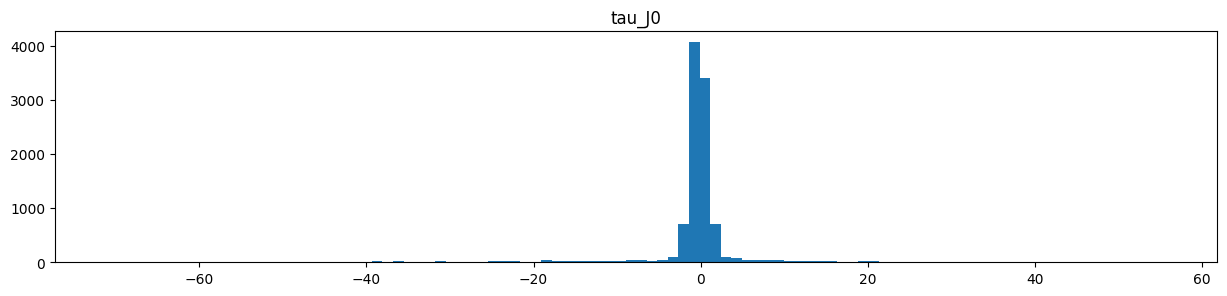

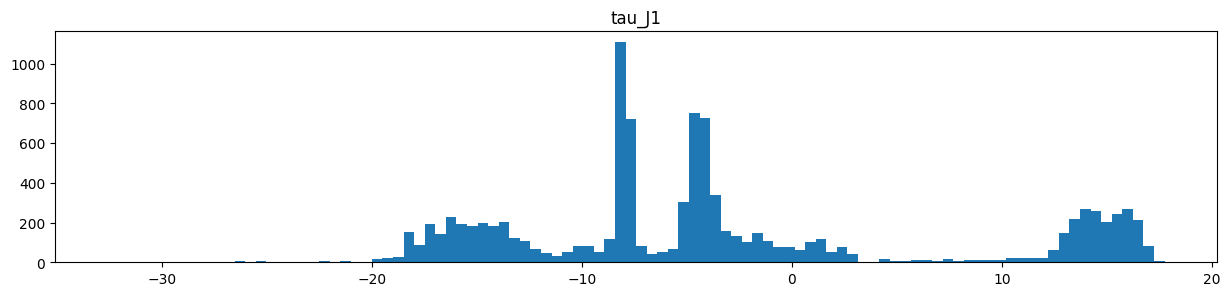

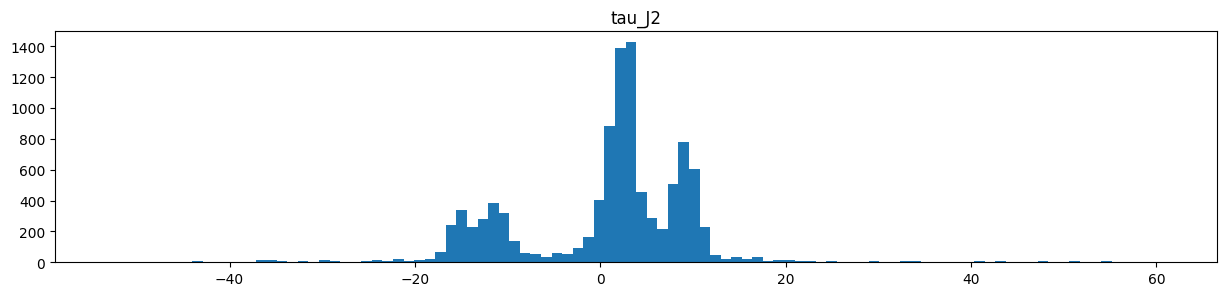

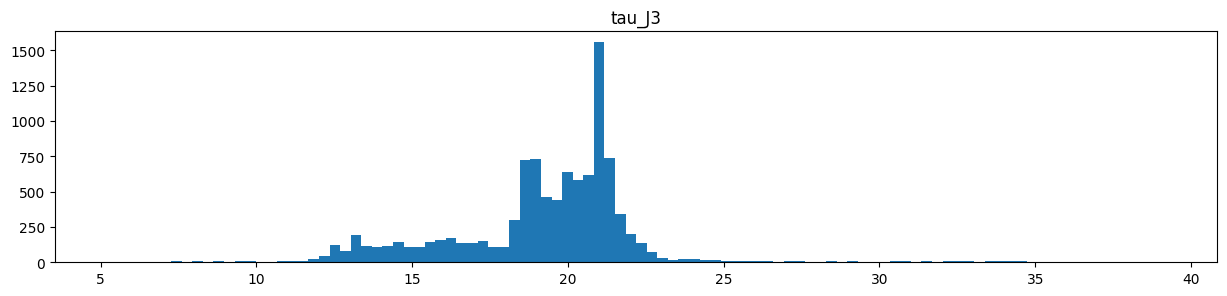

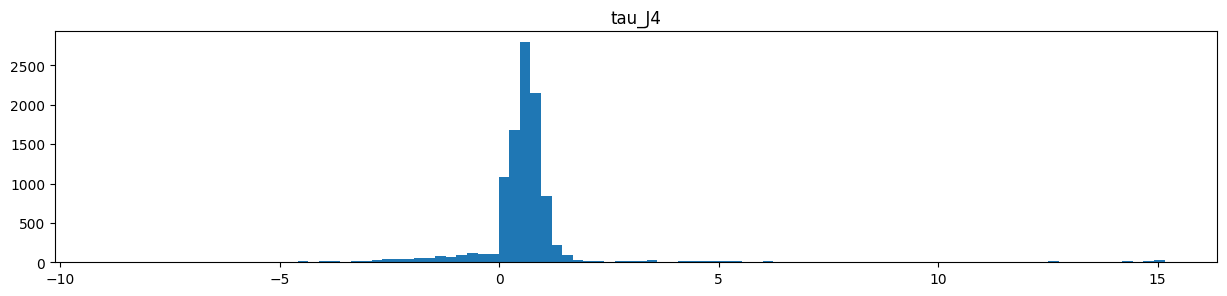

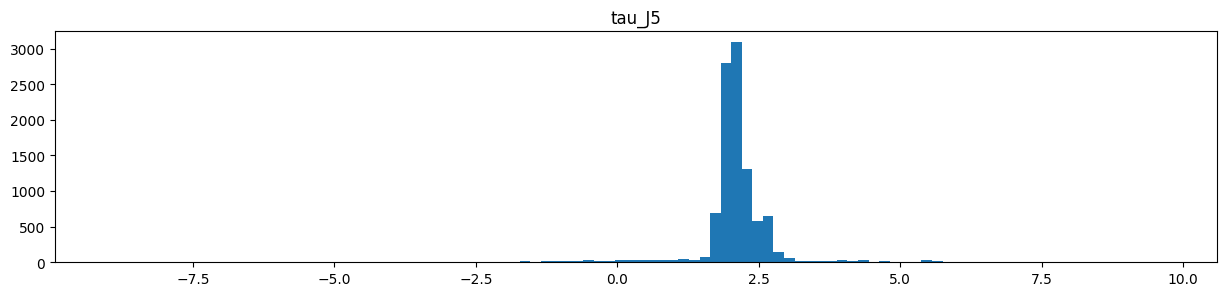

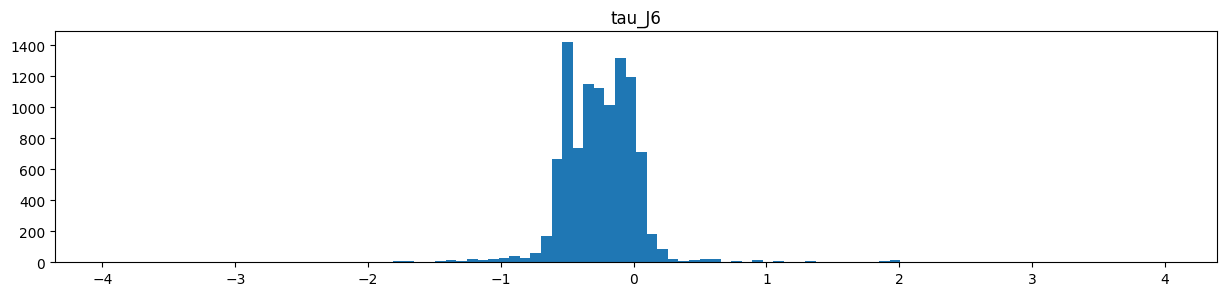

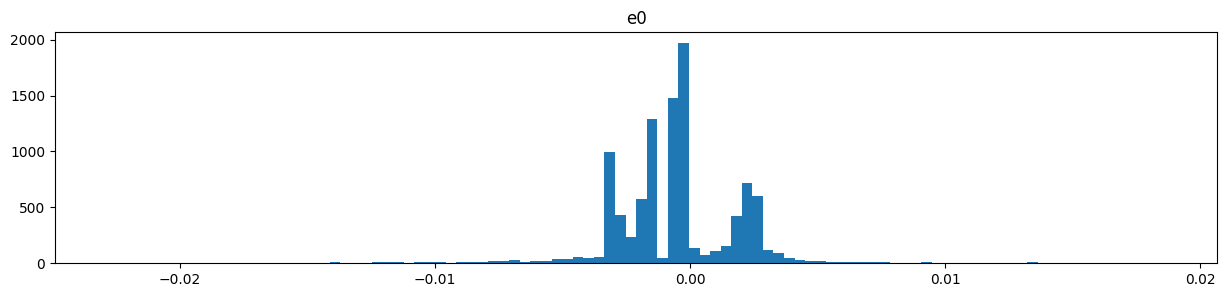

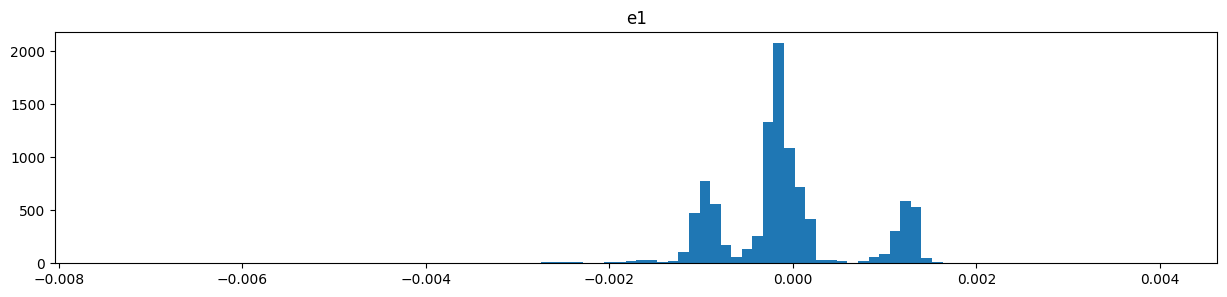

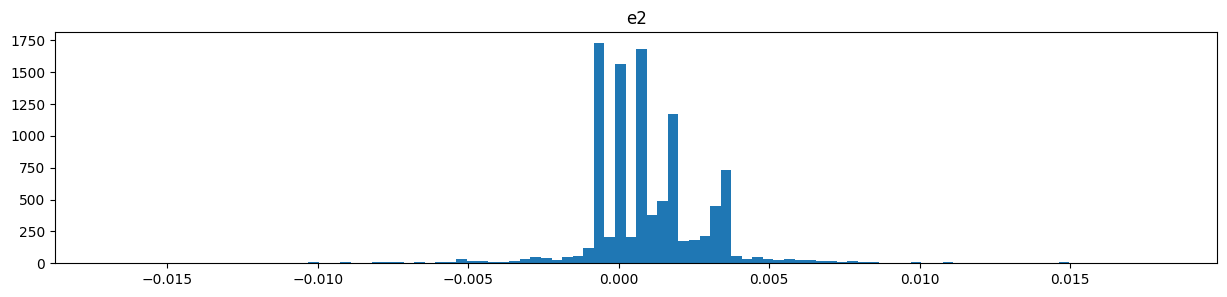

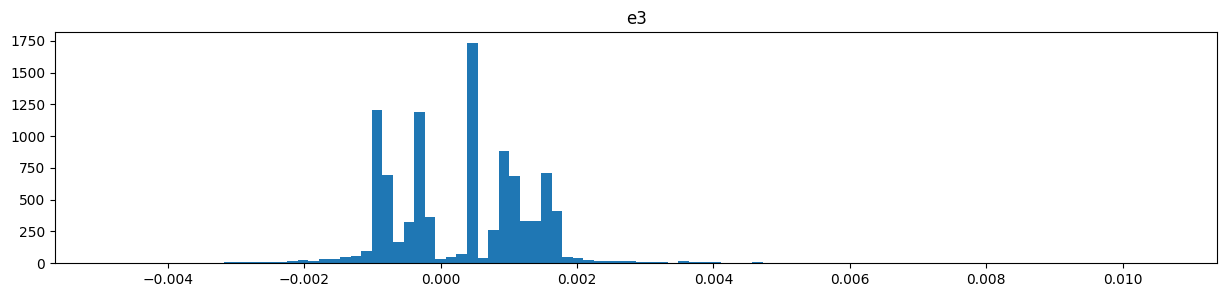

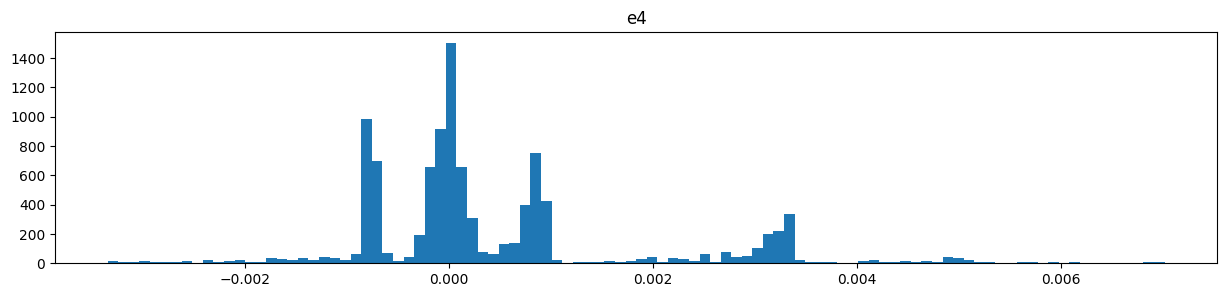

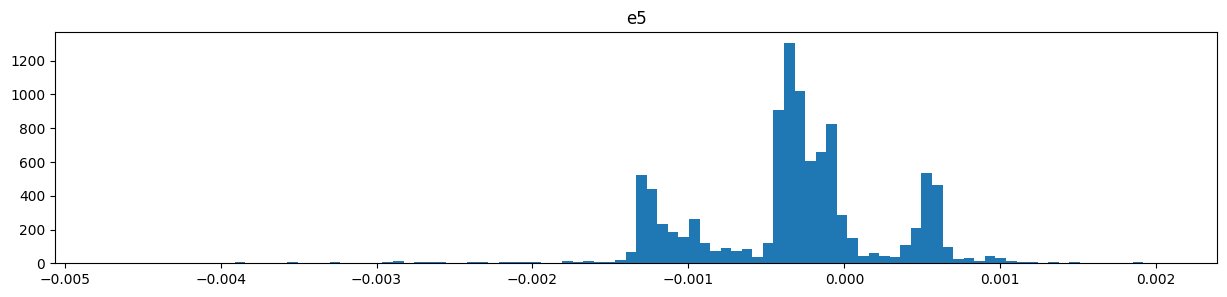

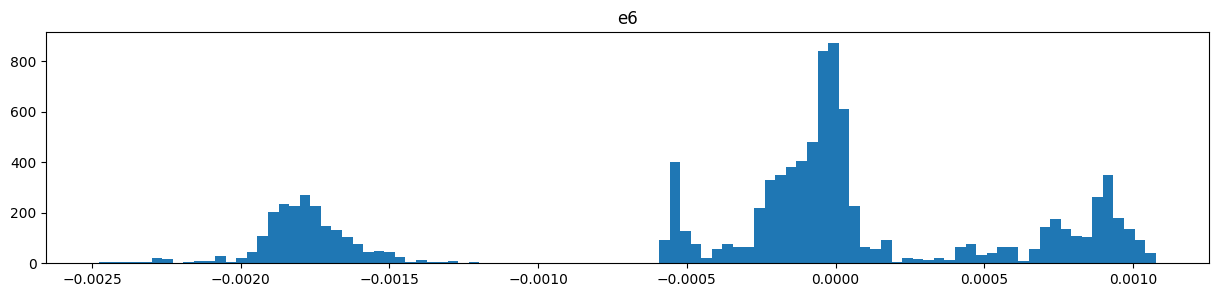

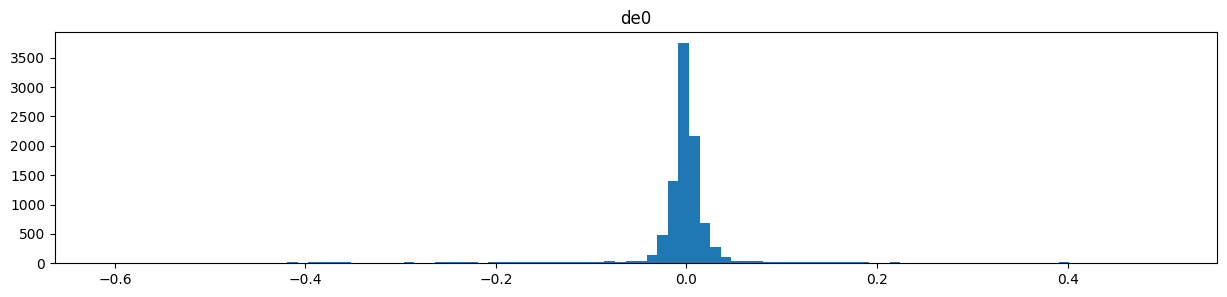

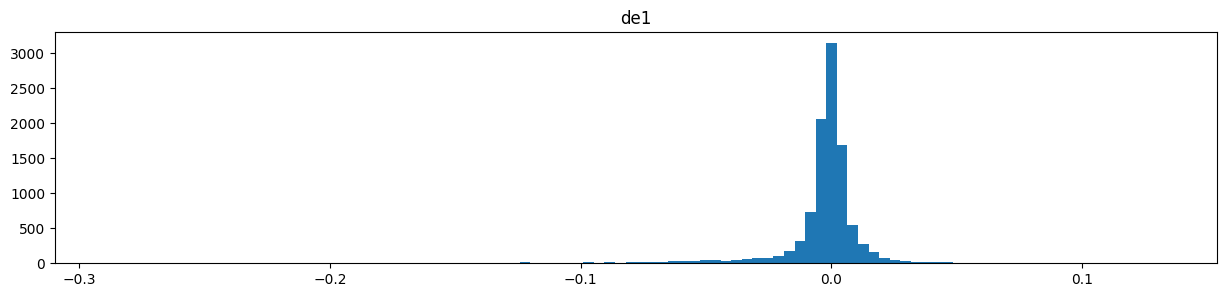

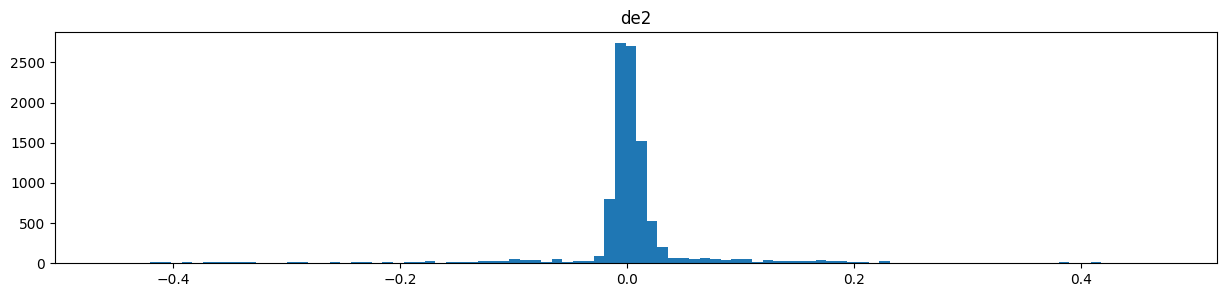

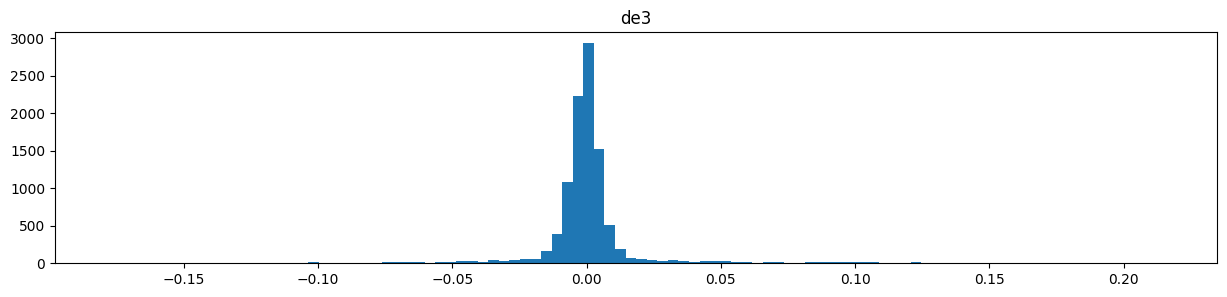

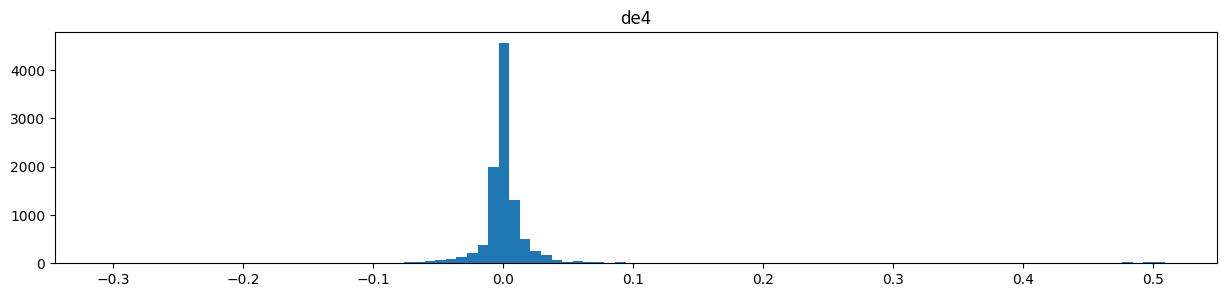

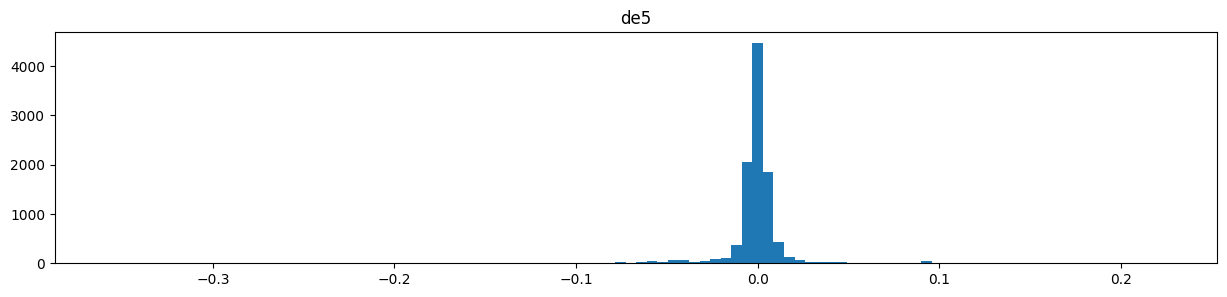

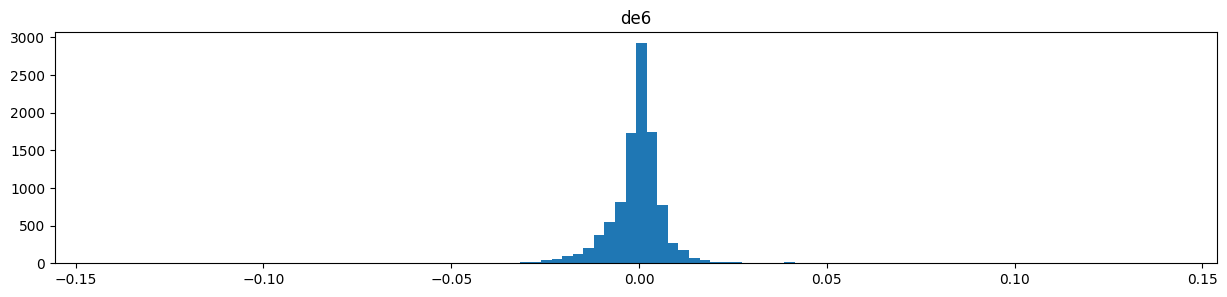

In [10]:
import matplotlib.pyplot as plt

# plot histogams of targets used in models (etau, e, de)
plot_targets = target_torque + target_position_err + target_velocity_err
for i, t in enumerate(all_targets):
    if t in plot_targets:
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.hist(X_single_left_offset[:,:, i].flatten(), bins=100)
        ax.set_title(t)
        plt.show()

plt.show()